In [ ]:
!unzip data.zip

#  Práctica Obligatoria - Parte I - Dataset

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">German Traffic Signs</p>***

En este Notebook se resumen las características del *dataset* a utilizar a lo largo de la práctica.

### German Traffic Sign (GTS)

El **German Traffic Sign** es un dataset ampliamente utilizado en tareas de clasificación y reconocimiento de señales de tráfico.

---

#### **Características del Dataset**
- **Cantidad de clases:** 43 clases de señales de tráfico, que incluyen límites de velocidad, prohibiciones, advertencias y otros tipos de señales.
- **Número de imágenes:** Alrededor de 50,000 imágenes para entrenamiento y validación, y aproximadamente 12,000 imágenes para prueba.
- **Dimensiones de las imágenes:** Resoluciones variables, típicamente entre 15x15 y 250x250 píxeles.
- **Formato de los datos:**
  - Cada imagen viene etiquetada con su clase correspondiente.
  - Metadatos como tamaño de la imagen, coordenadas del ROI (Región de Interés) y nombre de archivo están disponibles en archivos CSV.
  
---

#### **Licencia**
El dataset es de uso libre para fines educativos y de investigación.

Más información está disponible en el sitio oficial del benchmark: [GTSRB Dataset](http://benchmark.ini.rub.de/).

---

#### **Práctica**

En el contexto de esta práctica, se proporciona una adaptación de dicho conjunto de datos.

En particular, se proporcionan los datasets (`Dataset`) de PyTorch para trabajar con ellos.

### Evaluación - 1.5/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.5 puntos.
- **[Ejercicio 2]** 1 punto.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS

El conjunto de datos a utilizar será dividido en 3 partes:

In [4]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

Es decir, deberás utilizar siempre los conjuntos:
* `train_dataset`
* `valid_dataset`
* `test_dataset`

Dados estos tres conjuntos:
1. Cuenta cuántos ejemplos hay en cada uno.
2. Comprueba que, efectivamente, existen 43 clases.
3. Comprueba que las dimensiones de las imágenes son: 25x25x3.
4. Crea una función `visualize_subset(dataset, num_images)` que visualice un número dado de imágenes.

**[Ejercicio 1]**

----------------------------------------------------------
Número de ejemplos en el conjunto de entrenamiento: 19604
Número de ejemplos en el conjunto de validación: 19605
Número de ejemplos en el conjunto de test: 12630
Número de clases en el dataset: 43
Tamaño de las imágenes: torch.Size([3, 25, 25])
----------------------------------------------------------


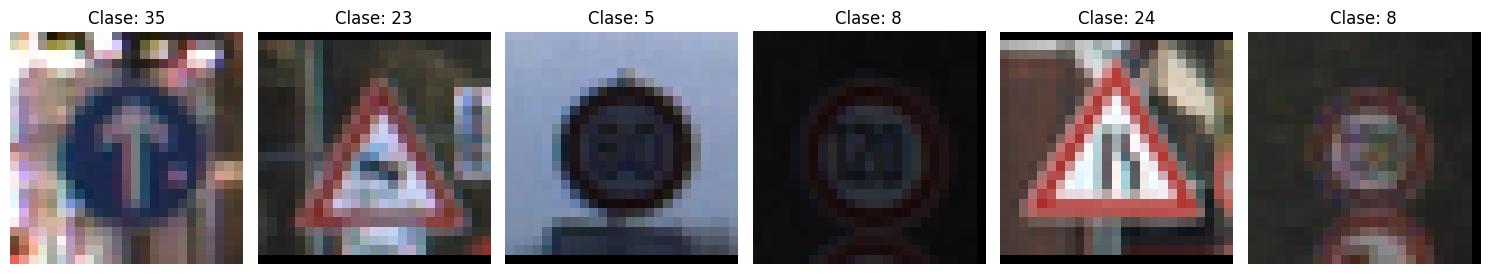

In [ ]:

# 1.
# Número de ejemplos en los conjuntos de entrenamiento y validación
num_train = len(train_dataset)
num_valid = len(valid_dataset)
num_test = len(test_dataset)

print("----------------------------------------------------------")
print(f"Número de ejemplos en el conjunto de entrenamiento: {num_train}")
print(f"Número de ejemplos en el conjunto de validación: {num_valid}")
print(f"Número de ejemplos en el conjunto de test: {num_test}")



# 2.
num_clases = max(train_dataset.data['ClassId']) + 1 # Existe la clase 0, por lo que debemos añadir uno
print(f"Número de clases en el dataset: {num_clases}")


# 3.
image_shape = train_dataset[0][0].shape
print(f"Tamaño de las imágenes: {image_shape}")
print("----------------------------------------------------------")


4.
# Visualizar algunos ejemplos
def visualize_subset(dataset, num_images=6):
    """
    Visualiza ejemplos directamente de un Subset o Dataset.

    :param dataset: Dataset o Subset que contiene las imágenes y etiquetas.
    :param num_images: Número de imágenes a mostrar.
    """
    indices = np.arange(num_images)
    images = []
    labels = []

    for idx in indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)

    images = torch.stack(images)     # Convertir la lista de imágenes en un tensor
    images = images.permute(0, 2, 3, 1)  # Permutar dimensiones para visualizar (batch, h, w, c)


    # Mostrar imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx in range(num_images):
        axes[idx].imshow(images[idx])
        axes[idx].set_title(f"Clase: {labels[idx]}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset)


Ahora que tienes acceso a los datos, crea un histograma de las clases para comprobar si están o no desbalanceadas:

<Axes: >

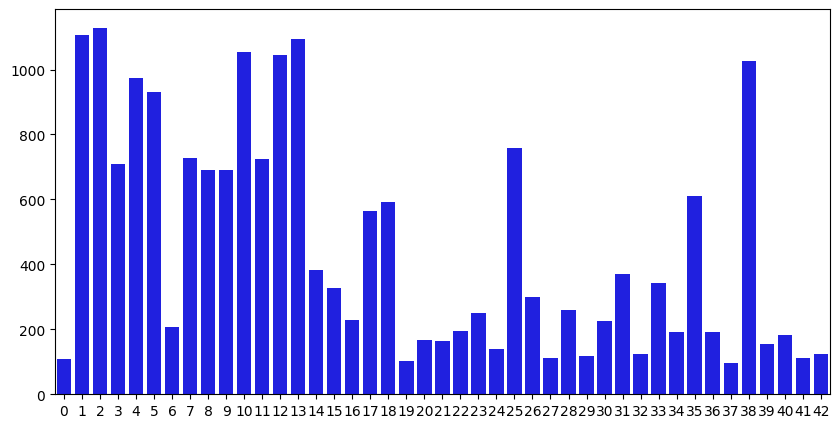

In [ ]:

# Crear un histograma
histograma, _ = np.histogram(train_dataset.data['ClassId'], bins=num_clases)


# Mostrar el gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(len(histograma))), y=histograma, color='blue')



Como puedes comprobar, las clases de este dataset están fuertemente desbalanceadas. Para paliar este posible problema, puedes crear un `sampler` específico y usarlo en el `dataloader`.

Ayúdate de la documentación de `WeightedRandomSampler`, para obtener un `dataloader` de manera que las clases tengan la misma probabilidad de ser muestreadas.

**[Ejercicio 2]**

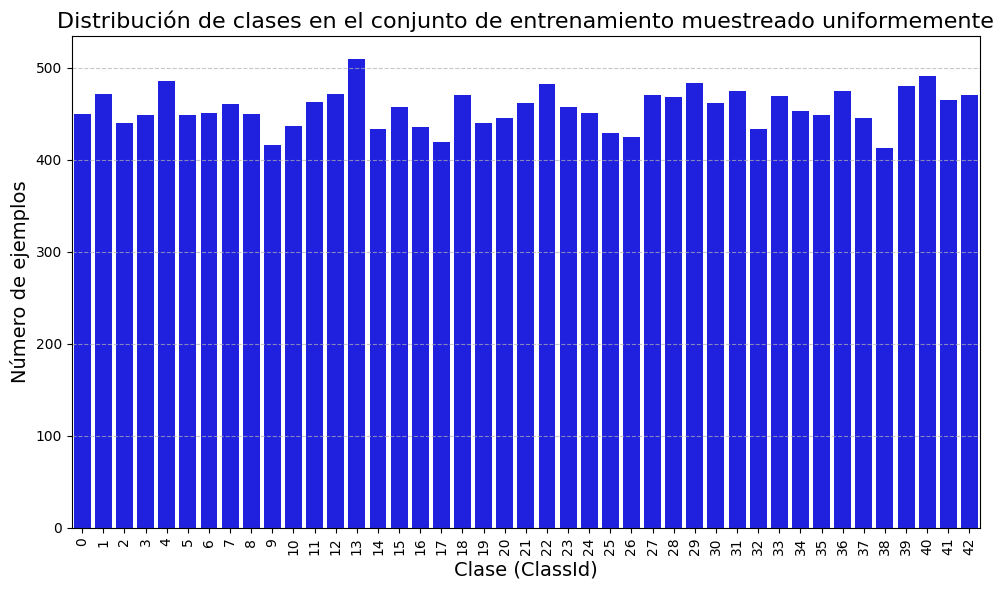

In [ ]:
from torch.utils.data import WeightedRandomSampler

batch_size = 16

# Paso 1: Calcular el histograma (frecuencias por clase)
histograma, _ = np.histogram(train_dataset.data['ClassId'], bins=num_clases)

# Paso 2: Asignar pesos inversamente proporcionales a las frecuencias
class_counts = np.bincount(train_dataset.data['ClassId'])
class_weights = 1.0 / class_counts

# Paso 3: Asignar pesos a cada ejemplo del dataset
labels = train_dataset.data['ClassId']
sample_weights = class_weights[labels] # cada ejemplo debe tener un peso asociado

# Paso 4: Crear el WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

# Paso 5: Crear el DataLoader con el sampler
train_dataloader_uniform = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

# Crear un contador para las clases sampleadas
sampled_labels = []

# Samplear las etiquetas usando el sampler
for data_batch, label_batch in train_dataloader_uniform:
    sampled_labels.extend(label_batch.numpy())

# Convertir las etiquetas sampleadas a un tensor y calcular el histograma
sampled_labels = torch.tensor(sampled_labels)
sampled_histogram = torch.bincount(sampled_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(len(sampled_histogram))), y=sampled_histogram.numpy(), color='blue')

# Personalización del gráfico
plt.title('Distribución de clases en el conjunto de entrenamiento muestreado uniformemente', fontsize=16)
plt.xlabel('Clase (ClassId)', fontsize=14)
plt.ylabel('Número de ejemplos', fontsize=14)
plt.xticks(ticks=range(len(sampled_histogram)), rotation=90)  # Mostrar todas las clases en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()